### Todo

#### This cell is for defining various OPTIONS used for this notebook (working directory, how many rows and columns pandas displays for a dataframe, etc). 

#### Preferably this cell is also where we do important imports (for example pandas and numpy)

In [1]:
import os 
#Input the directory where your joined_data.csv is located 
#os.chdir('C:/Users/Trond/Documents/Master 2020/Processed data')
os.chdir('C:/Users/Briggstone/Documents/Master 2020/Processed data')
#os.chdir('C:/Users/MyPC/Documents/Andrijana/UiS/DATMAS Master oppgave/Processed data')

#Where you want the csv file of the merged data to be placed
output_filepath = 'C:/Users/Briggstone/Documents/Master 2020/Processed data'
#output_filepath = 'C:/Users/MyPC/Documents/Andrijana/UiS/DATMAS Master oppgave/Processed data'

from matplotlib import pyplot
import pandas as pd 
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import svm

# Set ipython's max row display
pd.set_option('display.max_row', 1000)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 50)


#### In this cell we import our training data, convert HALL into HALL_EVER and select only BL observations.

In [2]:
train = pd.read_csv('train.csv')
temptrain = pd.DataFrame(train.PATNO.unique(), columns = ["PATNO"])

HALL_EVER = []
for id in train.PATNO.unique():
    if train.loc[(train.PATNO == id) & (train.HALL == 1), "HALL"].empty:
        HALL_EVER.append(0)
    else:
        HALL_EVER.append(1)

temptrain["HALL_EVER"] = HALL_EVER
train.drop("HALL", axis = 1, inplace = True)
train = train.merge(temptrain, how = "inner", on = "PATNO")

#Selecting only Baseline observations
train = train.loc[train.EVENT_ID == "BL", :]

#We can then safely drop EVENT_ID
train.drop("EVENT_ID", axis = 1, inplace = True)

# We form Y
Y = train.pop("HALL_EVER")

In [3]:
train.shape

(293, 22)

#### In this cell we apply random forest from XGBOOST

   train-error-mean  train-error-std  train-auc-mean  train-auc-std  \
0          0.153197         0.013717        0.940077       0.009606   

   train-aucpr-mean  train-aucpr-std  test-error-mean  test-error-std  \
0          0.877348         0.017941         0.262414        0.075404   

   test-auc-mean  test-auc-std  test-aucpr-mean  test-aucpr-std  
0       0.626962       0.15283         0.486562        0.171873  


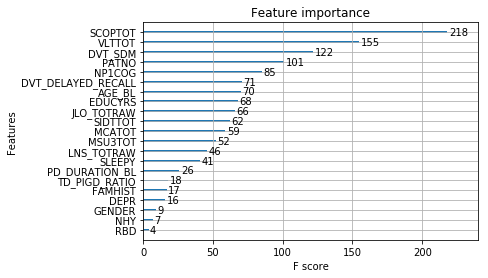

In [4]:
dtrain = xgb.DMatrix(train, label = Y)


#Random Forest
params = {
  'colsample_bynode': 0.8,
  'learning_rate': 1,
  'max_depth': 5,
  'num_parallel_tree': 100,
  'objective': 'binary:logistic',
  'subsample': 0.8,
  'tree_method': 'auto'
}

cv_results_RF = xgb.cv(params, dtrain = dtrain, num_boost_round=1, nfold = 10, as_pandas = True, seed = 1, metrics = ["error", "auc", "aucpr"])
print(cv_results_RF)

model_RF = xgb.train(params, dtrain, num_boost_round=1)
xgb.plot_importance(model_RF)
pyplot.show()

#### In this cell we apply random forest from XGBOOST

   train-error-mean  train-error-std  train-auc-mean  train-auc-std  \
0          0.156232         0.013033        0.862937       0.027906   
1          0.124767         0.011462        0.930231       0.014878   
2          0.108453         0.010569        0.960893       0.010525   
3          0.087977         0.011834        0.980617       0.005354   
4          0.072809         0.010411        0.989722       0.004287   
5          0.053474         0.010112        0.995254       0.002271   
6          0.040578         0.008989        0.998217       0.001393   
7          0.029580         0.011478        0.999255       0.000636   
8          0.020099         0.006574        0.999774       0.000226   
9          0.013652         0.008160        0.999985       0.000029   

   train-aucpr-mean  train-aucpr-std  test-error-mean  test-error-std  \
0          0.768329         0.031719         0.330805        0.107947   
1          0.870377         0.020673         0.313678        0.087784   

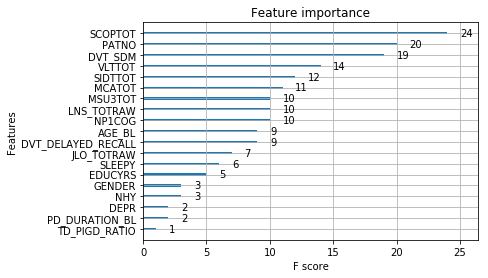

In [5]:
#Boosted trees
params = {
  'objective': 'binary:logistic',
  'tree_method': 'auto'
}

cv_results_BT = xgb.cv(params, dtrain = dtrain, num_boost_round=10, nfold = 10, as_pandas = True, seed = 1, metrics = ["error", "auc", "aucpr"])
print(cv_results_BT)

model_BT = xgb.train(params, dtrain, num_boost_round=10)
xgb.plot_importance(model_BT)
pyplot.show()

#### In this cell we apply SVM from scikit-learn

In [6]:
clf1 = svm.SVC(random_state=0, gamma='auto', kernel='rbf')
roc_auc1 = cross_val_score(clf1, train, Y, cv=10, scoring='roc_auc')
roc_auc1

array([0.59090909, 0.49431818, 0.40340909, 0.45238095, 0.49404762,
       0.46428571, 0.60714286, 0.45833333, 0.33333333, 0.29761905])

In [7]:
accuracy1 = cross_val_score(clf1, train, Y, cv=10, scoring='accuracy')
accuracy1

array([0.73333333, 0.73333333, 0.63333333, 0.68965517, 0.72413793,
       0.68965517, 0.72413793, 0.72413793, 0.68965517, 0.72413793])

In [8]:
clf2 = svm.SVC(random_state=0, gamma='auto', kernel='linear')
roc_auc2 = cross_val_score(clf2, train, Y, cv=10, scoring='roc_auc')
roc_auc2

array([0.65909091, 0.63068182, 0.57386364, 0.5       , 0.57738095,
       0.70238095, 0.72619048, 0.57738095, 0.76190476, 0.66666667])

In [9]:
accuracy2 = cross_val_score(clf2, train, Y, cv=10, scoring='accuracy')
accuracy2

array([0.66666667, 0.73333333, 0.7       , 0.65517241, 0.75862069,
       0.75862069, 0.79310345, 0.68965517, 0.79310345, 0.75862069])